Read in [Barclay et al. (2018)](http://adsabs.harvard.edu/abs/2018arXiv180405050B) synthetic yield and determine which planetary eclipses we could see with TESS.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import simps
import pickle

from astropy import units as u
from astropy import constants as const
from astropy.modeling.blackbody import blackbody_lambda

In [2]:
Barclay_filename = 'detected_planets.csv'
Barclay_data = np.genfromtxt(Barclay_filename, names=True, delimiter=',', dtype=None)

print(Barclay_data.dtype.names)

('TICID', 'RAdeg', 'DEdeg', 'ELON', 'ELAT', 'Priority', '2mintarget', 'Camera', 'Obslen', 'Numsectors', 'Vmag', 'Kmag', 'Tmag', 'Starradius', 'Starmass', 'Distance', 'Subgiant', 'Detected', 'Detectedcons', 'Planetperiod', 'Planetradius', 'Ntransits', 'Ars', 'Ecc', 'Rprs', 'Impact', 'Duration', 'Depthobs', 'Insol', 'Noiselevel', 'SNR')


First, let's calculate the eclipse depths $\Delta$, assuming 100% albedos $\omega$, as follows:
$\Delta = \dfrac{\omega}{4} \left( \dfrac{R_*}{a} \right)^2 \left( \dfrac{R_{\rm p}}{R_*} \right)^2$.

To calculate the resulting signal-to-noise ratio, we divide the SNR field in the Barclay file by the planet-to-star radius ratio squared, and then multiply by the estimated visible eclipse depth.

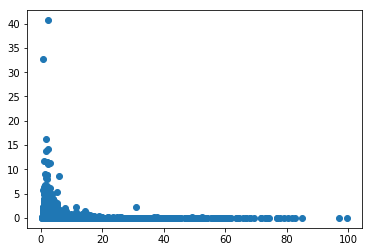

In [3]:
visible_albedo = 1.
visible_eclipses = visible_albedo/4./Barclay_data['Ars']**2*Barclay_data['Rprs']**2
visible_eclipses_SNR = visible_eclipses/Barclay_data['Rprs']**2*Barclay_data['SNR']

plt.scatter(Barclay_data['Planetperiod'], visible_eclipses_SNR)

Next, we'll calculate the eclipse depths, assuming the planets are perfect blackbodies and that the only signal observed by TESS is the blackbody emission in the [TESS bandpass](https://heasarc.gsfc.nasa.gov/docs/tess/).

In this case, the planet's brightness temperature is given by $T_{\rm p} = \sqrt[4]{\dfrac{F_*}{2 \sigma}}$, where $F_*$ is the stellar flux at the distance of the planet from the star (proportional to the 'Insol' data field in the Barclay data file) and $\sigma$ is the Stefan-Boltzmann constant.

With that brightness temperature, I then calculate the blackbody radiation curve for the planet, $B(T_{\rm p})$ and integrate it over the TESS bandpass. 

To then calculate the planetary eclipse depth, I also need the stellar luminosity, but Barclay doesn't give me the stellar temperatures. However, I can back out the effective stellar temperature using the 'Insol' and the 'Ars' (which represents the planet's semi-major axis to stellar radius ratio) data fields as $T_* = \sqrt[4]{ \dfrac{F_*}{\sigma} \left( \dfrac{a}{R_*} \right)^2 }$.

So integrating the stellar blackbody radiation over the TESS band gives the brightness. If I divide the planetary TESS-band brightness by the stellar and then multiply by the planet-star radius ratio, that should give me an approximate eclipse depth.

Then I can calculate the corresponding SNR via the same scheme as for the visible eclipses.

3888.0406914113305


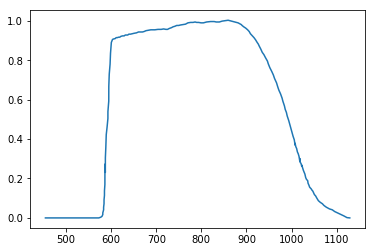

In [4]:
# Read in TESS response function
TESS_func_filename = 'tess-response-function-v1.0.csv'

TESS_func = np.genfromtxt(TESS_func_filename, comments='#', names=True, delimiter=',')
plt.plot(TESS_func['Wavelength'], TESS_func['Transmission'])

# A quick sanity check
print(simps(TESS_func['Transmission'], x=TESS_func['Wavelength']*10))

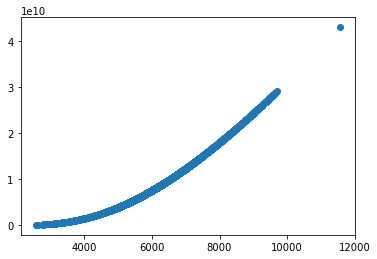

In [8]:
solar_const = 1361. # watts per square meter W/m^2

Insol_MKS = Barclay_data['Insol']*solar_const
Ts = (Insol_MKS/const.sigma_sb.value*Barclay_data['Ars']**2)**(1./4) # K

# Requires Angstroms
stellar_bolo = np.array([simps(blackbody_lambda(TESS_func['Wavelength']*10, Ts[i])*TESS_func['Transmission'],
                               x=TESS_func['Wavelength']*10) for i in range(len(Ts))])
pickle.dump( (Ts, stellar_bolo), open( "stellar_bolo.pickle", "wb" ) )
results = pickle.load( open( "stellar_bolo.pickle", "rb" ) )
Ts = results[0]
stellar_bolo = results[1]

plt.scatter(Ts, stellar_bolo)

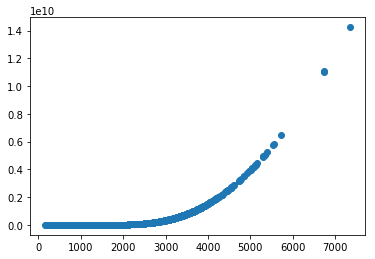

In [10]:
Tp = (Insol_MKS/2./const.sigma_sb.value)**(1./4)
planetary_bolo = np.array([simps(blackbody_lambda(TESS_func['Wavelength']*10, Tp[i])*TESS_func['Transmission'],
                                 x=TESS_func['Wavelength']*10) for i in range(len(Ts))])
pickle.dump( (Tp, planetary_bolo), open( "planetary_bolo.pickle", "wb" ) )

results = pickle.load( open( "planetary_bolo.pickle", "rb" ) )
Tp = results[0]
planetary_bolo = results[1]

plt.scatter(Tp, planetary_bolo)

(0.1, 1000.0)

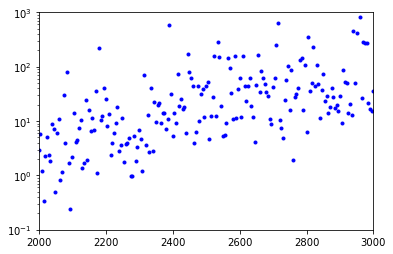

In [53]:
# 2019 Mar 17 - For LPSC talk
Rprs = np.sort(Barclay_data['Rprs'])
emitted_eclipses = planetary_bolo/stellar_bolo*Rprs**2

Tp_arrs = np.linspace(2000, 3000, 201)

srt = np.argsort(Tp)
eclipse_arrs = np.interp(Tp_arrs, Tp[srt], emitted_eclipses[srt])

# plt.semilogy(Tp, emitted_eclipses*1e6, 'b.')
srt = np.argsort(Tp_arrs)
plt.semilogy(Tp_arrs[srt], eclipse_arrs[srt]*1e6, 'b.')
plt.xlim([2000, 3000])
plt.ylim([1e-1, 1e3])

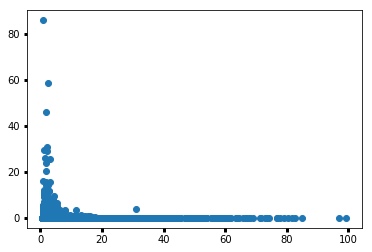

In [6]:
emitted_eclipses = planetary_bolo/stellar_bolo*Barclay_data['Rprs']**2
emitted_eclipses_SNR = emitted_eclipses/Barclay_data['Rprs']**2*Barclay_data['SNR']
plt.scatter(Barclay_data['Planetperiod'], emitted_eclipses_SNR)

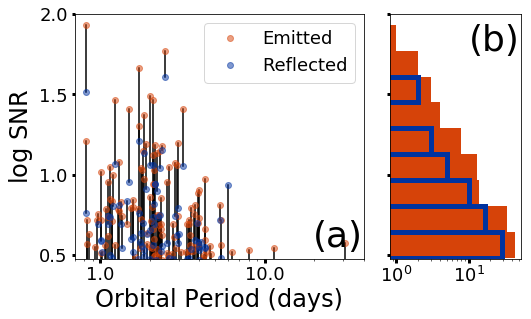

In [35]:
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(8, 4.5))
ax = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)

# https://brandstandards.boisestate.edu/colors/
orange = '#D64309'
blue = '#0033A0'

for i in range(len(Barclay_data['Planetperiod'])):
    ax.semilogx([Barclay_data['Planetperiod'][i], Barclay_data['Planetperiod'][i]], 
          [np.log10(emitted_eclipses_SNR[i]), np.log10(visible_eclipses_SNR[i])], 
          marker='', color='black')

ax.semilogx(Barclay_data['Planetperiod'], np.log10(emitted_eclipses_SNR), 
          marker='o', ls='', color=orange, label='Emitted', alpha=0.5)
ax.semilogx(Barclay_data['Planetperiod'], np.log10(visible_eclipses_SNR), 
            marker='o', ls='', color=blue, label='Reflected', alpha=0.5)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
ax.set_xlabel('Orbital Period (days)', fontsize=24)
ax.set_ylabel('$\\log$ SNR', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.legend(loc='upper right', fontsize=18)

ax2 = plt.subplot2grid((3,3), (0,2), colspan=1, rowspan=3, sharey=ax)

ind = emitted_eclipses_SNR > 3
n, bins, patches = ax2.hist(np.log10(emitted_eclipses_SNR[ind]), 
                            log=True, bins='auto', color=orange, orientation="horizontal")
ind = visible_eclipses_SNR > 3
ax2.hist(np.log10(visible_eclipses_SNR[ind]), 
         log=True, bins=bins, edgecolor=blue, lw=5, fill=False, orientation="horizontal")
ax2.tick_params(labelleft='off', labeltop='off', labelright='off', labelsize=18)

ax.set_xlim([0.7, 40])
ax.set_ylim([np.log10(3), 2])

ax.annotate('(a)', 
            fontsize=36, xy=(0.5, 0.5), xytext=(0.825, 0.05), xycoords='axes fraction', textcoords='axes fraction')

ax2.annotate('(b)', 
            fontsize=36, xy=(0.5, 0.5), xytext=(0.6, 0.85), xycoords='axes fraction', textcoords='axes fraction')

fig.savefig('../eclipse_estimates.jpg', dpi=500, bbox_inches='tight')

62
54
61
1


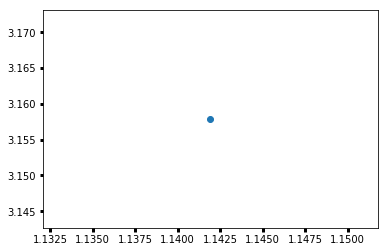

In [10]:
ind = (emitted_eclipses_SNR > 3) & (visible_eclipses_SNR > 3)
print(len(Barclay_data['Planetperiod'][ind]))
ind = (Barclay_data['Planetradius'] > 10.) & (emitted_eclipses_SNR > 3) & (visible_eclipses_SNR > 3)
print(len(Barclay_data['Planetperiod'][ind]))
ind = (Barclay_data['Planetradius'] > 4.) & (emitted_eclipses_SNR > 3) & (visible_eclipses_SNR > 3)
print(len(Barclay_data['Planetperiod'][ind]))
ind = (Barclay_data['Planetradius'] < 4.) & (emitted_eclipses_SNR > 3) & (visible_eclipses_SNR > 3)
print(len(Barclay_data['Planetperiod'][ind]))

plt.scatter(Barclay_data['Planetperiod'][ind], visible_eclipses_SNR[ind])

Text(0,0.5,'emitted')

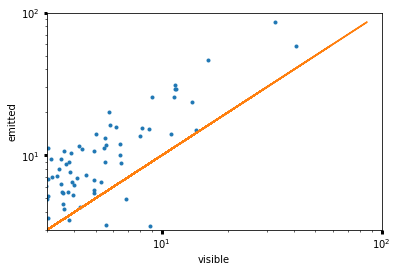

In [21]:
plt.loglog(visible_eclipses_SNR, emitted_eclipses_SNR, marker='.', ls='')
plt.loglog(emitted_eclipses_SNR, emitted_eclipses_SNR)
plt.xlim([3, 100])
plt.ylim([3, 100])

plt.xlabel('visible')
plt.ylabel('emitted')

(1.8644726266503393, 3635.8571691581255, 6026.815844113176, 13.728802922258954)


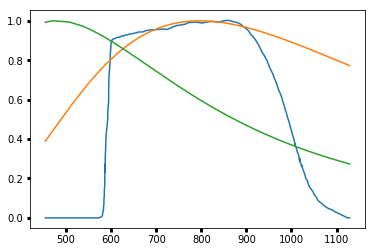

In [50]:
#ind = np.argmax(emitted_eclipses_SNR/visible_eclipses_SNR)

ratio = emitted_eclipses_SNR/visible_eclipses_SNR
ind = (emitted_eclipses_SNR > 3) & (visible_eclipses_SNR > 3)

temp_ratio = ratio[ind]
temp_Tp = Tp[ind]
temp_Ts = Ts[ind]
temp_period = Barclay_data['Planetperiod'][ind]

ind = np.argsort(temp_ratio)[len(temp_ratio)/2]

planetary_BB = blackbody_lambda(TESS_func['Wavelength']*10, temp_Tp[ind])
stellar_BB = blackbody_lambda(TESS_func['Wavelength']*10, temp_Ts[ind])
print(temp_ratio[ind], temp_Tp[ind], temp_Ts[ind], Barclay_data['Planetperiod'][ind])

plt.plot(TESS_func['Wavelength'], TESS_func['Transmission'])
plt.plot(TESS_func['Wavelength'], planetary_BB/np.max(planetary_BB))
plt.plot(TESS_func['Wavelength'], stellar_BB/np.max(stellar_BB))

2018 Jul 26 <br>
I want to compare the results from TESS to what I would expect for the same population of planets observed by Kepler.

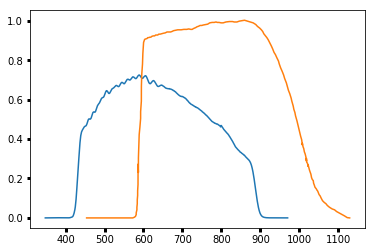

In [26]:
# Read in Kepler response function
Kepler_func_filename = 'kepler_response_hires1.txt'

Kepler_func = np.genfromtxt(Kepler_func_filename, names='Wavelength, Transmission')
plt.plot(Kepler_func['Wavelength'], Kepler_func['Transmission'])
plt.plot(TESS_func['Wavelength'], TESS_func['Transmission'])

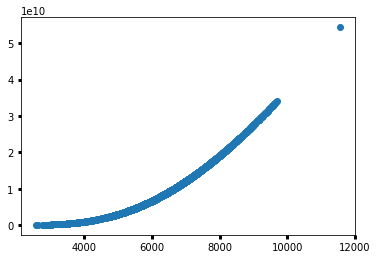

In [27]:
solar_const = 1361. # watts per square meter W/m^2

Insol_MKS = Barclay_data['Insol']*solar_const
Ts = (Insol_MKS/const.sigma_sb.value*Barclay_data['Ars']**2)**(1./4) # K

# Requires Angstroms
Kepler_stellar_bolo = np.array([simps(blackbody_lambda(Kepler_func['Wavelength']*10, Ts[i])*Kepler_func['Transmission'],
                               x=Kepler_func['Wavelength']*10) for i in range(len(Ts))])
pickle.dump( (Ts, Kepler_stellar_bolo), open( "Kepler_stellar_bolo.pickle", "wb" ) )
results = pickle.load( open( "Kepler_stellar_bolo.pickle", "rb" ) )
Ts = results[0]
Kepler_stellar_bolo = results[1]

plt.scatter(Ts, Kepler_stellar_bolo)

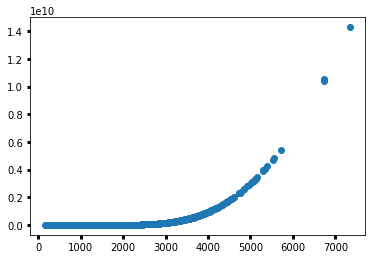

In [29]:
Tp = (Insol_MKS/2./const.sigma_sb.value)**(1./4)
Kepler_planetary_bolo = np.array([simps(blackbody_lambda(Kepler_func['Wavelength']*10, Tp[i])*Kepler_func['Transmission'],
                                 x=Kepler_func['Wavelength']*10) for i in range(len(Ts))])
pickle.dump( (Tp, Kepler_planetary_bolo), open( "Kepler_planetary_bolo.pickle", "wb" ) )

results = pickle.load( open( "Kepler_planetary_bolo.pickle", "rb" ) )
Tp = results[0]
Kepler_planetary_bolo = results[1]

plt.scatter(Tp, Kepler_planetary_bolo)

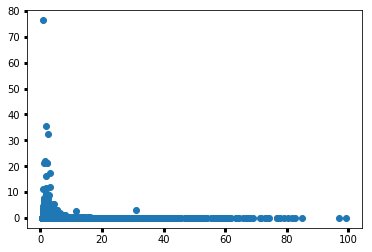

In [30]:
emitted_eclipses = Kepler_planetary_bolo/Kepler_stellar_bolo*Barclay_data['Rprs']**2
emitted_eclipses_SNR = emitted_eclipses/Barclay_data['Rprs']**2*Barclay_data['SNR']
plt.scatter(Barclay_data['Planetperiod'], emitted_eclipses_SNR)

/Users/bjackson/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.6,0.85,'(b)')

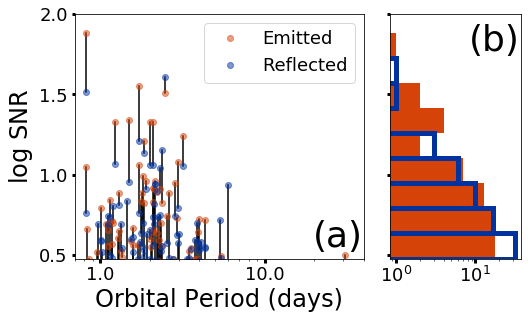

In [31]:
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(8, 4.5))
ax = plt.subplot2grid((3,3), (0,0), colspan=2, rowspan=3)

# https://brandstandards.boisestate.edu/colors/
orange = '#D64309'
blue = '#0033A0'

for i in range(len(Barclay_data['Planetperiod'])):
    ax.semilogx([Barclay_data['Planetperiod'][i], Barclay_data['Planetperiod'][i]], 
          [np.log10(emitted_eclipses_SNR[i]), np.log10(visible_eclipses_SNR[i])], 
          marker='', color='black')

ax.semilogx(Barclay_data['Planetperiod'], np.log10(emitted_eclipses_SNR), 
          marker='o', ls='', color=orange, label='Emitted', alpha=0.5)
ax.semilogx(Barclay_data['Planetperiod'], np.log10(visible_eclipses_SNR), 
            marker='o', ls='', color=blue, label='Reflected', alpha=0.5)

for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
    
ax.set_xlabel('Orbital Period (days)', fontsize=24)
ax.set_ylabel('$\\log$ SNR', fontsize=24)
ax.tick_params(which='both', labelsize=18)
ax.legend(loc='upper right', fontsize=18)

ax2 = plt.subplot2grid((3,3), (0,2), colspan=1, rowspan=3, sharey=ax)

ind = emitted_eclipses_SNR > 3
n, bins, patches = ax2.hist(np.log10(emitted_eclipses_SNR[ind]), 
                            log=True, bins='auto', color=orange, orientation="horizontal")
ind = visible_eclipses_SNR > 3
ax2.hist(np.log10(visible_eclipses_SNR[ind]), 
         log=True, bins=bins, edgecolor=blue, lw=5, fill=False, orientation="horizontal")
ax2.tick_params(labelleft='off', labeltop='off', labelright='off', labelsize=18)

ax.set_xlim([0.7, 40])
ax.set_ylim([np.log10(3), 2])

ax.annotate('(a)', 
            fontsize=36, xy=(0.5, 0.5), xytext=(0.825, 0.05), xycoords='axes fraction', textcoords='axes fraction')

ax2.annotate('(b)', 
            fontsize=36, xy=(0.5, 0.5), xytext=(0.6, 0.85), xycoords='axes fraction', textcoords='axes fraction')